### Do the measurement of the line peaks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as c
from astropy import constants as const
from astropy.io import fits
import emcee, corner

In [2]:
## FITS data
hdu = fits.open("goodsn-42-G141_01060.2D.fits")
sci_d = hdu['SCI'].data
sci_h = hdu['SCI'].header
wl = np.linspace(1*sci_h['CRVAL1'],1*sci_h['CRVAL1'] + ((sci_h['NAXIS1']-1)*sci_h["CD1_1"]),sci_h['NAXIS1'])

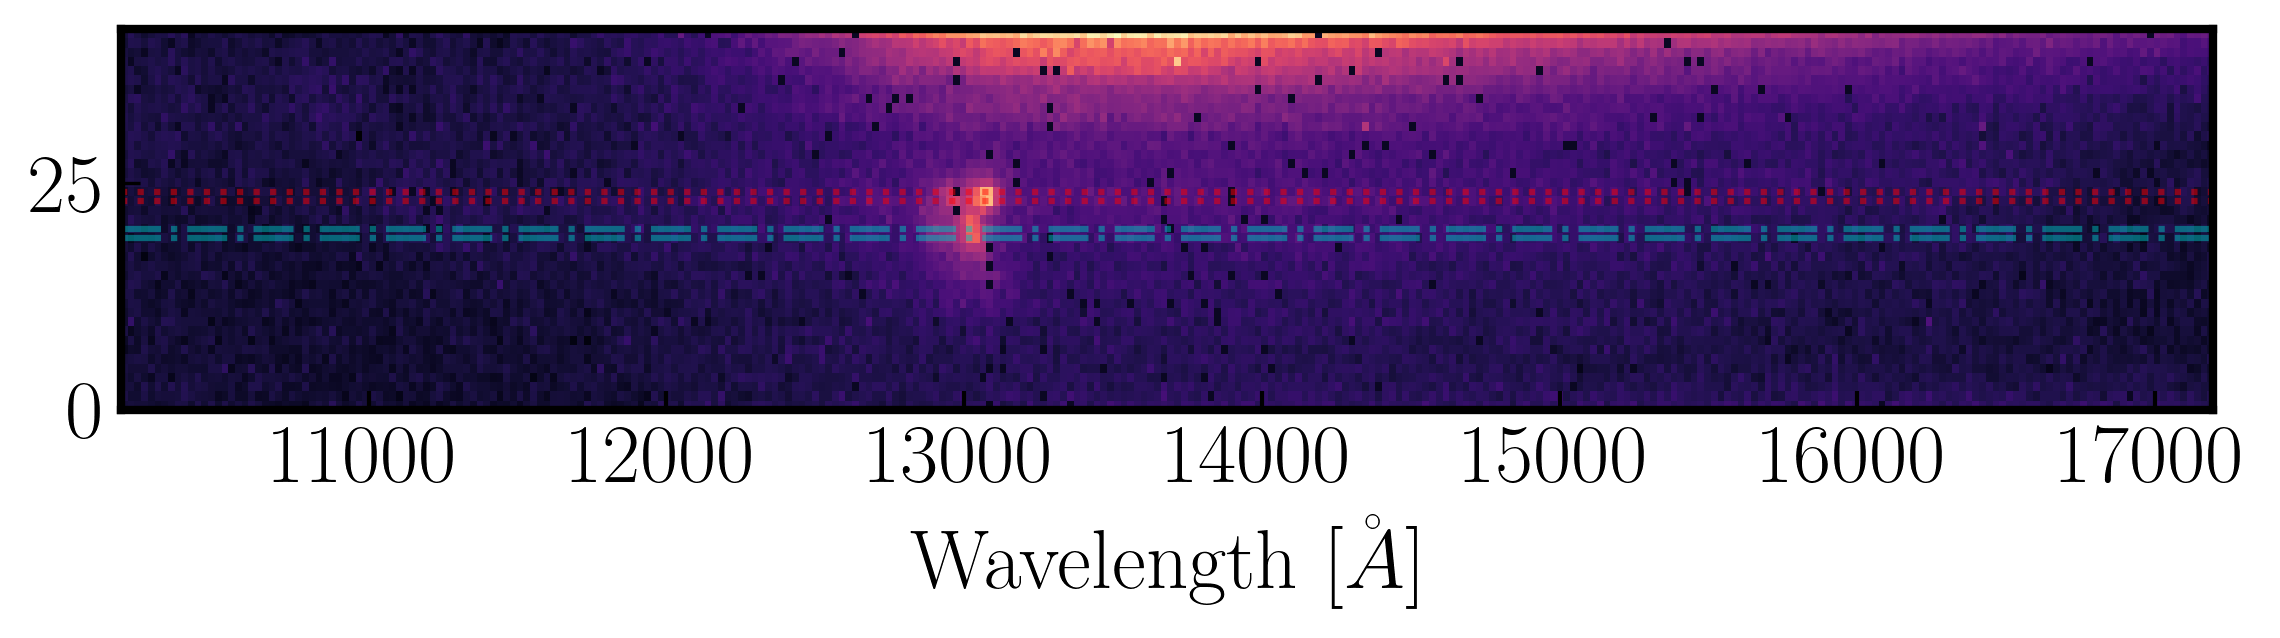

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(sci_d,origin='lower',extent=[wl[0],wl[-1],0,42])
ax.set_aspect(sci_h['NAXIS1']/sci_h['NAXIS2']*4)
ax.set_xlabel('Wavelength [$\AA$]')
ax.axhline(24,c='r',ls=':',alpha=0.5)
ax.axhline(23,c='r',ls=':',alpha=0.5)
ax.axhline(20,c='c',ls='-.',alpha=0.5)
ax.axhline(19,c='c',ls='-.',alpha=0.5)
plt.show()

In [4]:
## These are the rest frame line values for OIII
O3_A = 5006.843 ## in angstroms!
O3_B= 4958.911 ## in angstroms!
z = 1.6095

## Convert to observer frame
O3_A_obs = O3_A*(1+z)
O3_B_obs = O3_B*(1+z)

## Observed peaks of OIII line
ns = np.nanmean(hdu['SCI'].data[23:25,110:140],axis=0)
ss = np.nanmean(hdu['SCI'].data[19:21,110:140],axis=0)
wl_s = wl[110:140]

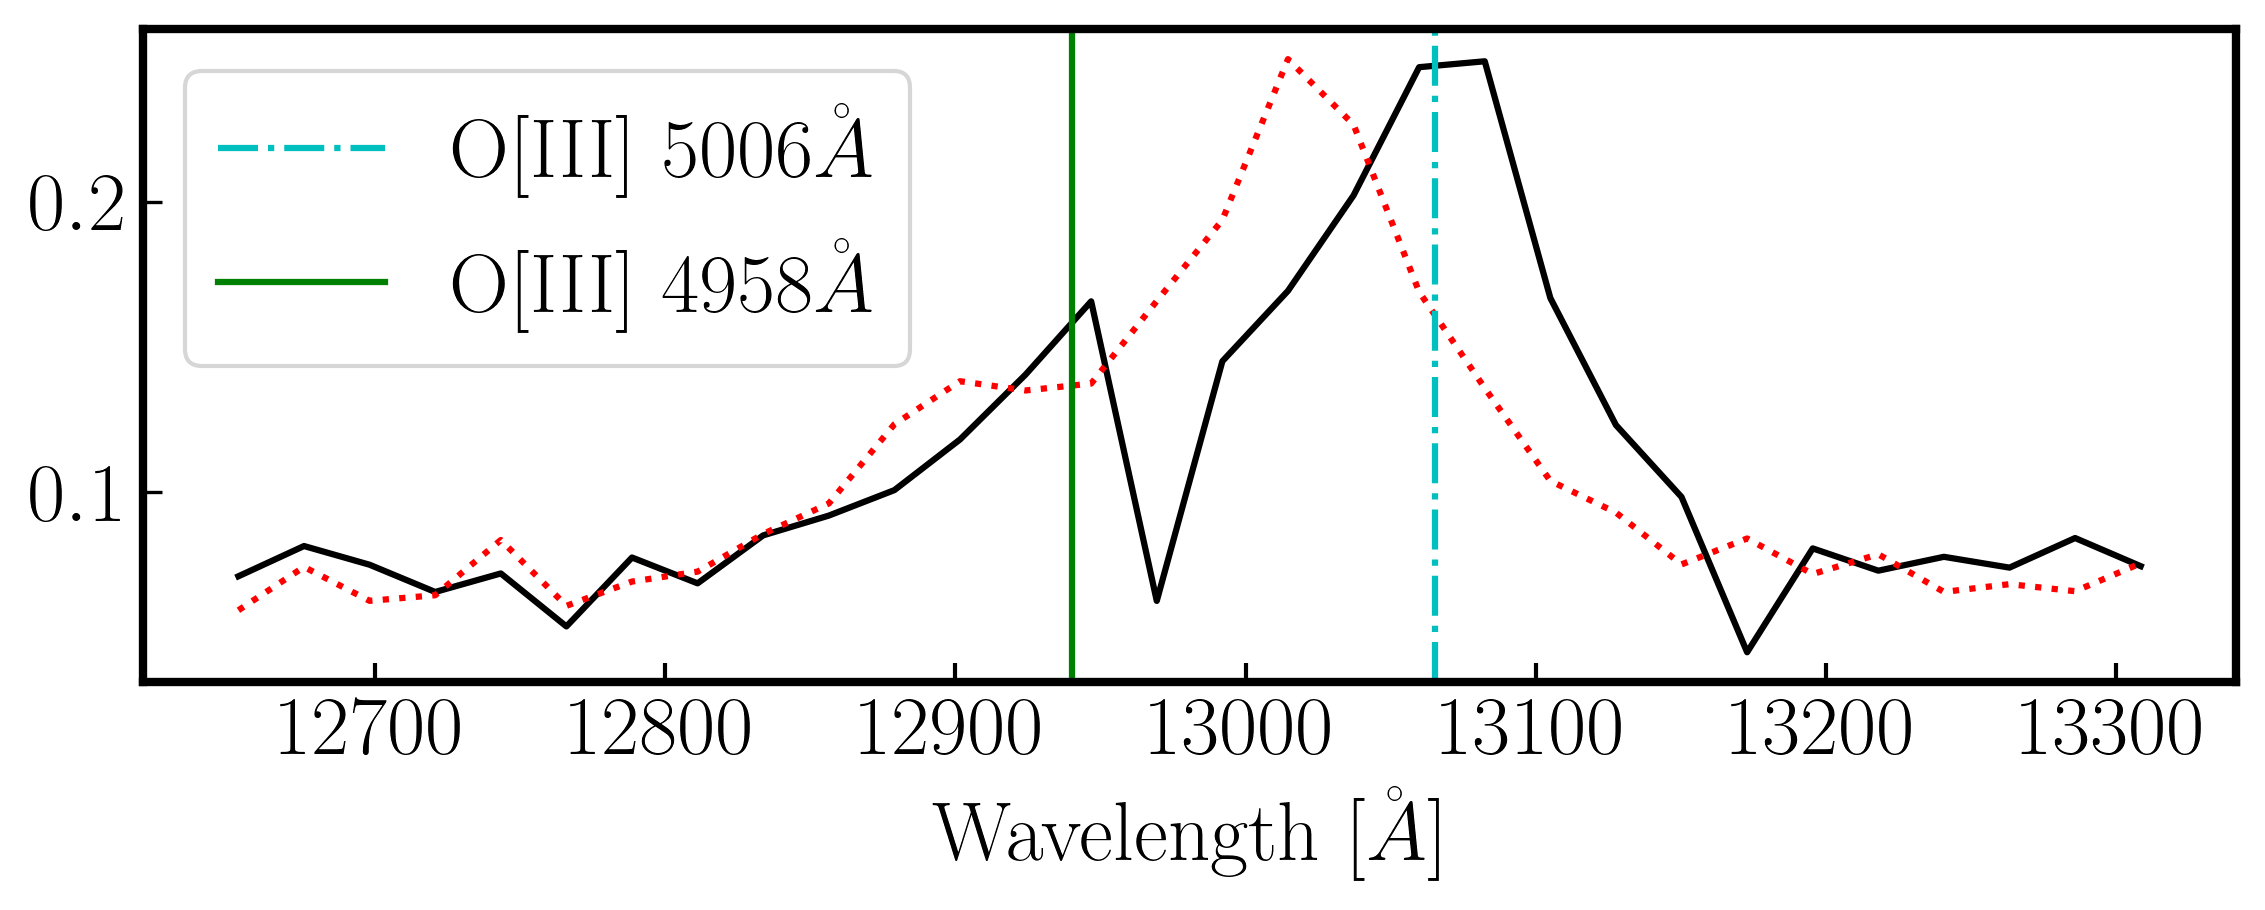

In [5]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(wl[110:140],ns,'k-')
ax.plot(wl[110:140],ss,'r:')
ax.axvline(O3_A_obs,ls='-.',c='c',label="O[III] 5006$\AA$")
ax.axvline(O3_B_obs,ls='-',c='g',label="O[III] 4958$\AA$")
ax.set_xlabel('Wavelength [$\AA$]')
ax.set_aspect(1000)
ax.legend()

## We did the fitting so this is just me testing
nsp_wl = wl_s[np.where(ns==ns.max())]
ssp_wl = wl_s[np.where(ss==ss.max())]

### Calculate the velocities

In [6]:
print("Obs frame OIII lines wavelengths: %.3f, %.3f [Angstroms]"%(O3_A_obs,O3_B_obs))

def doppler(wl,wl_0):
    return c.c*((wl-wl_0)/wl_0)[0]

ns_v = doppler(wl=nsp_wl,wl_0=O3_A_obs)
ss_v = doppler(wl=ssp_wl,wl_0=O3_A_obs)
vdiff = ns_v-ss_v

print("Velocities: North = %.2f km/s, South = %.2f km/s"%(ns_v/1e3,ss_v/1e3))
print("Velocity difference v1-v2 = %.2f km/s"%(vdiff/1e3))

Obs frame OIII lines wavelengths: 13065.357, 12940.278 [Angstroms]
Velocities: North = 390.85 km/s, South = -1164.65 km/s
Velocity difference v1-v2 = 1555.50 km/s


### Calculate the model for the B-SMBH

Going to use the following model:

$$ v_1 + v_2 = |v_1|-|v_2| = \left(\frac{2\pi m_\mathrm{tot}\sin^3(i)G}{P}\right)^{1/3}$$

Reduce dimensions:

v1 + v2 ~ $10^{6}$, G ~ $10^{-11}$,  2pi ~ $10^{0}$, 1/P ~ $10^{-13}$, mtot ~ $10^{38}$ kg

In log10 space:

$$\log(v_1 + v_2) = (1/3)\left[\log{2\pi G} + \log(m_\mathrm{tot}) + \log(\sin^3(i)) - \log(P)\right]$$

^ the $v_1$ - $v_2$ is the same as the simple model that RD used it's just that the signs of the velocities are reversed

In [83]:
## define the model first
def kepler_model(theta):
    m1,m2,P = theta
    sin3i = 2/3
    return np.log10(((2*c.pi*c.G*sin3i*(m1+m2))/P)**(1/3))

In [84]:
def lnlike(theta, dv, dv_err):
    return -0.5 * np.sum(((dv - kepler_model(theta))/dv_err) ** 2)

In [132]:
def lnprior(theta):
    m1,m2,P = theta
    if 1 < m1 < 1e10 and  1 < m2 < 1e10 and  1 < P < 1e10:
        return 0.0
    return -np.inf

In [133]:
def lnprob(theta, dv, dv_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, dv, dv_err)

In [141]:
nwalkers = 512
niter = 10000
initial = np.array([1e8, 1e8, 1e5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [142]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data,moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,)

    return sampler, pos, prob, state

In [143]:
scaler = (const.M_sun.value)**(1/3)
data = (vdiff/scaler,vdiff/10/scaler)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


Text(0.5, 0, 'step number')

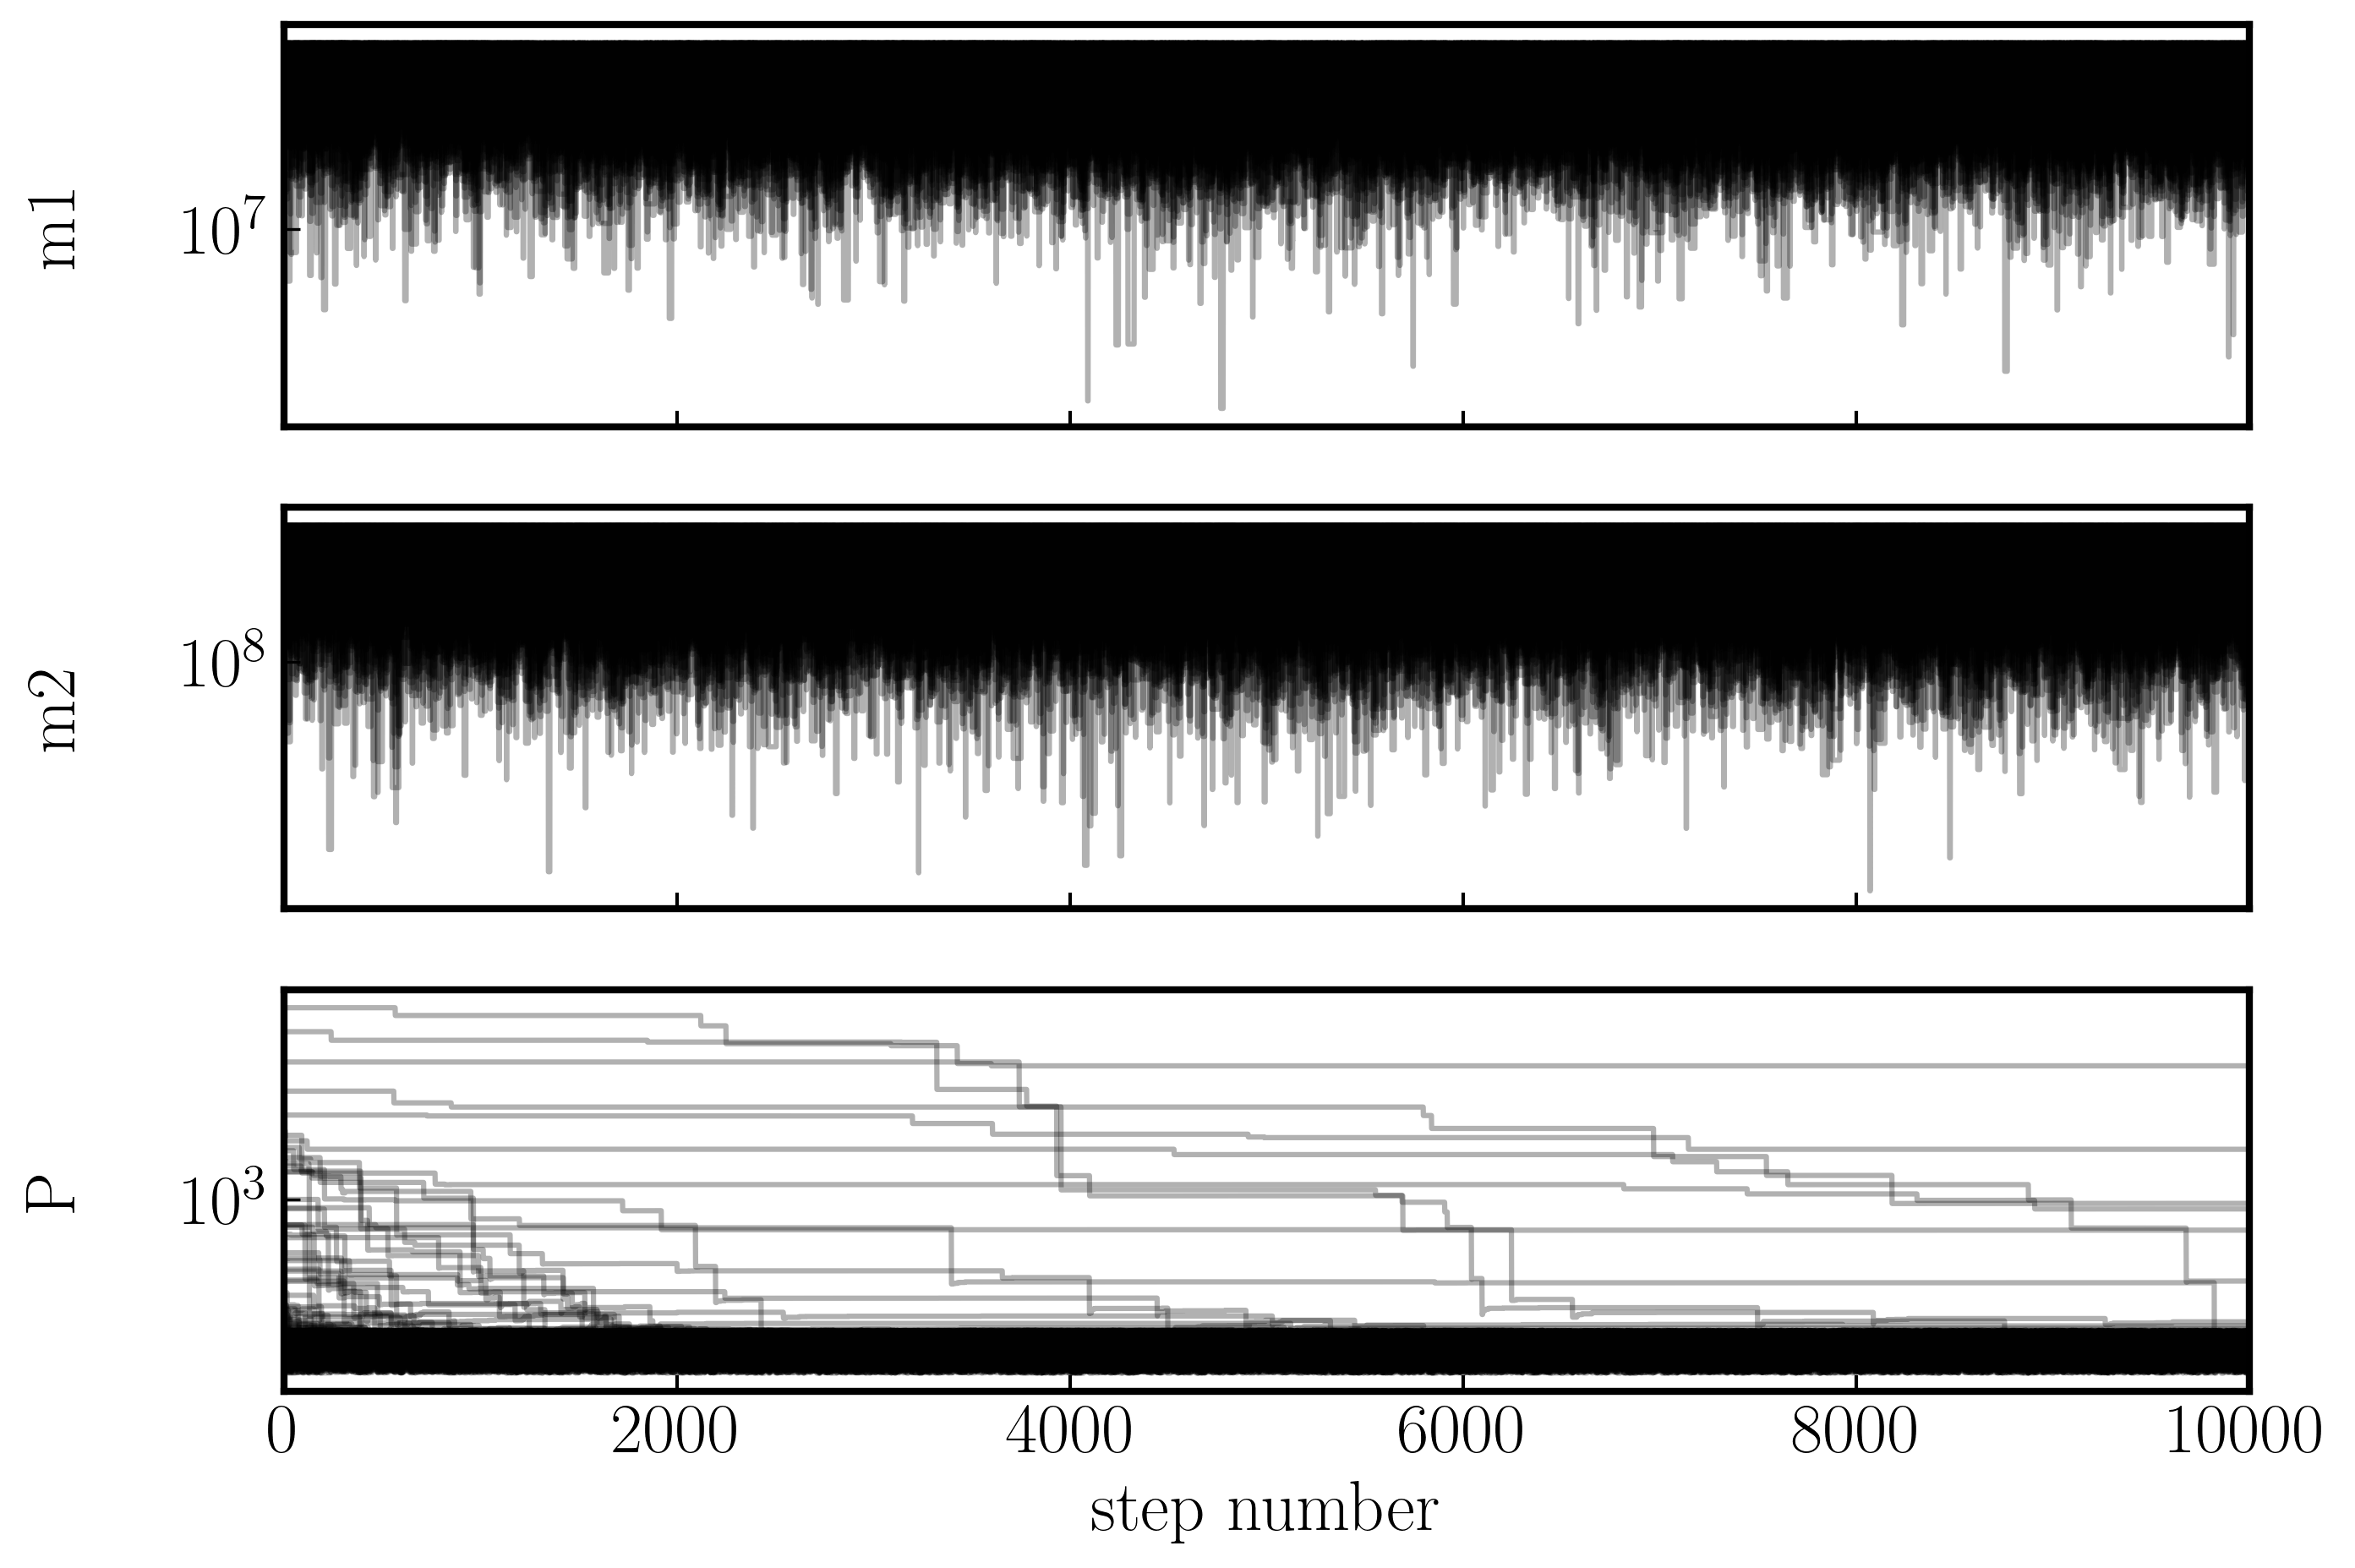

In [144]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "P","sin3i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3,rasterized=True)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_yscale("log")

axes[-1].set_xlabel("step number")

In [145]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([5.20508762e+09, 2.61944182e+09, 2.18565426e+00])

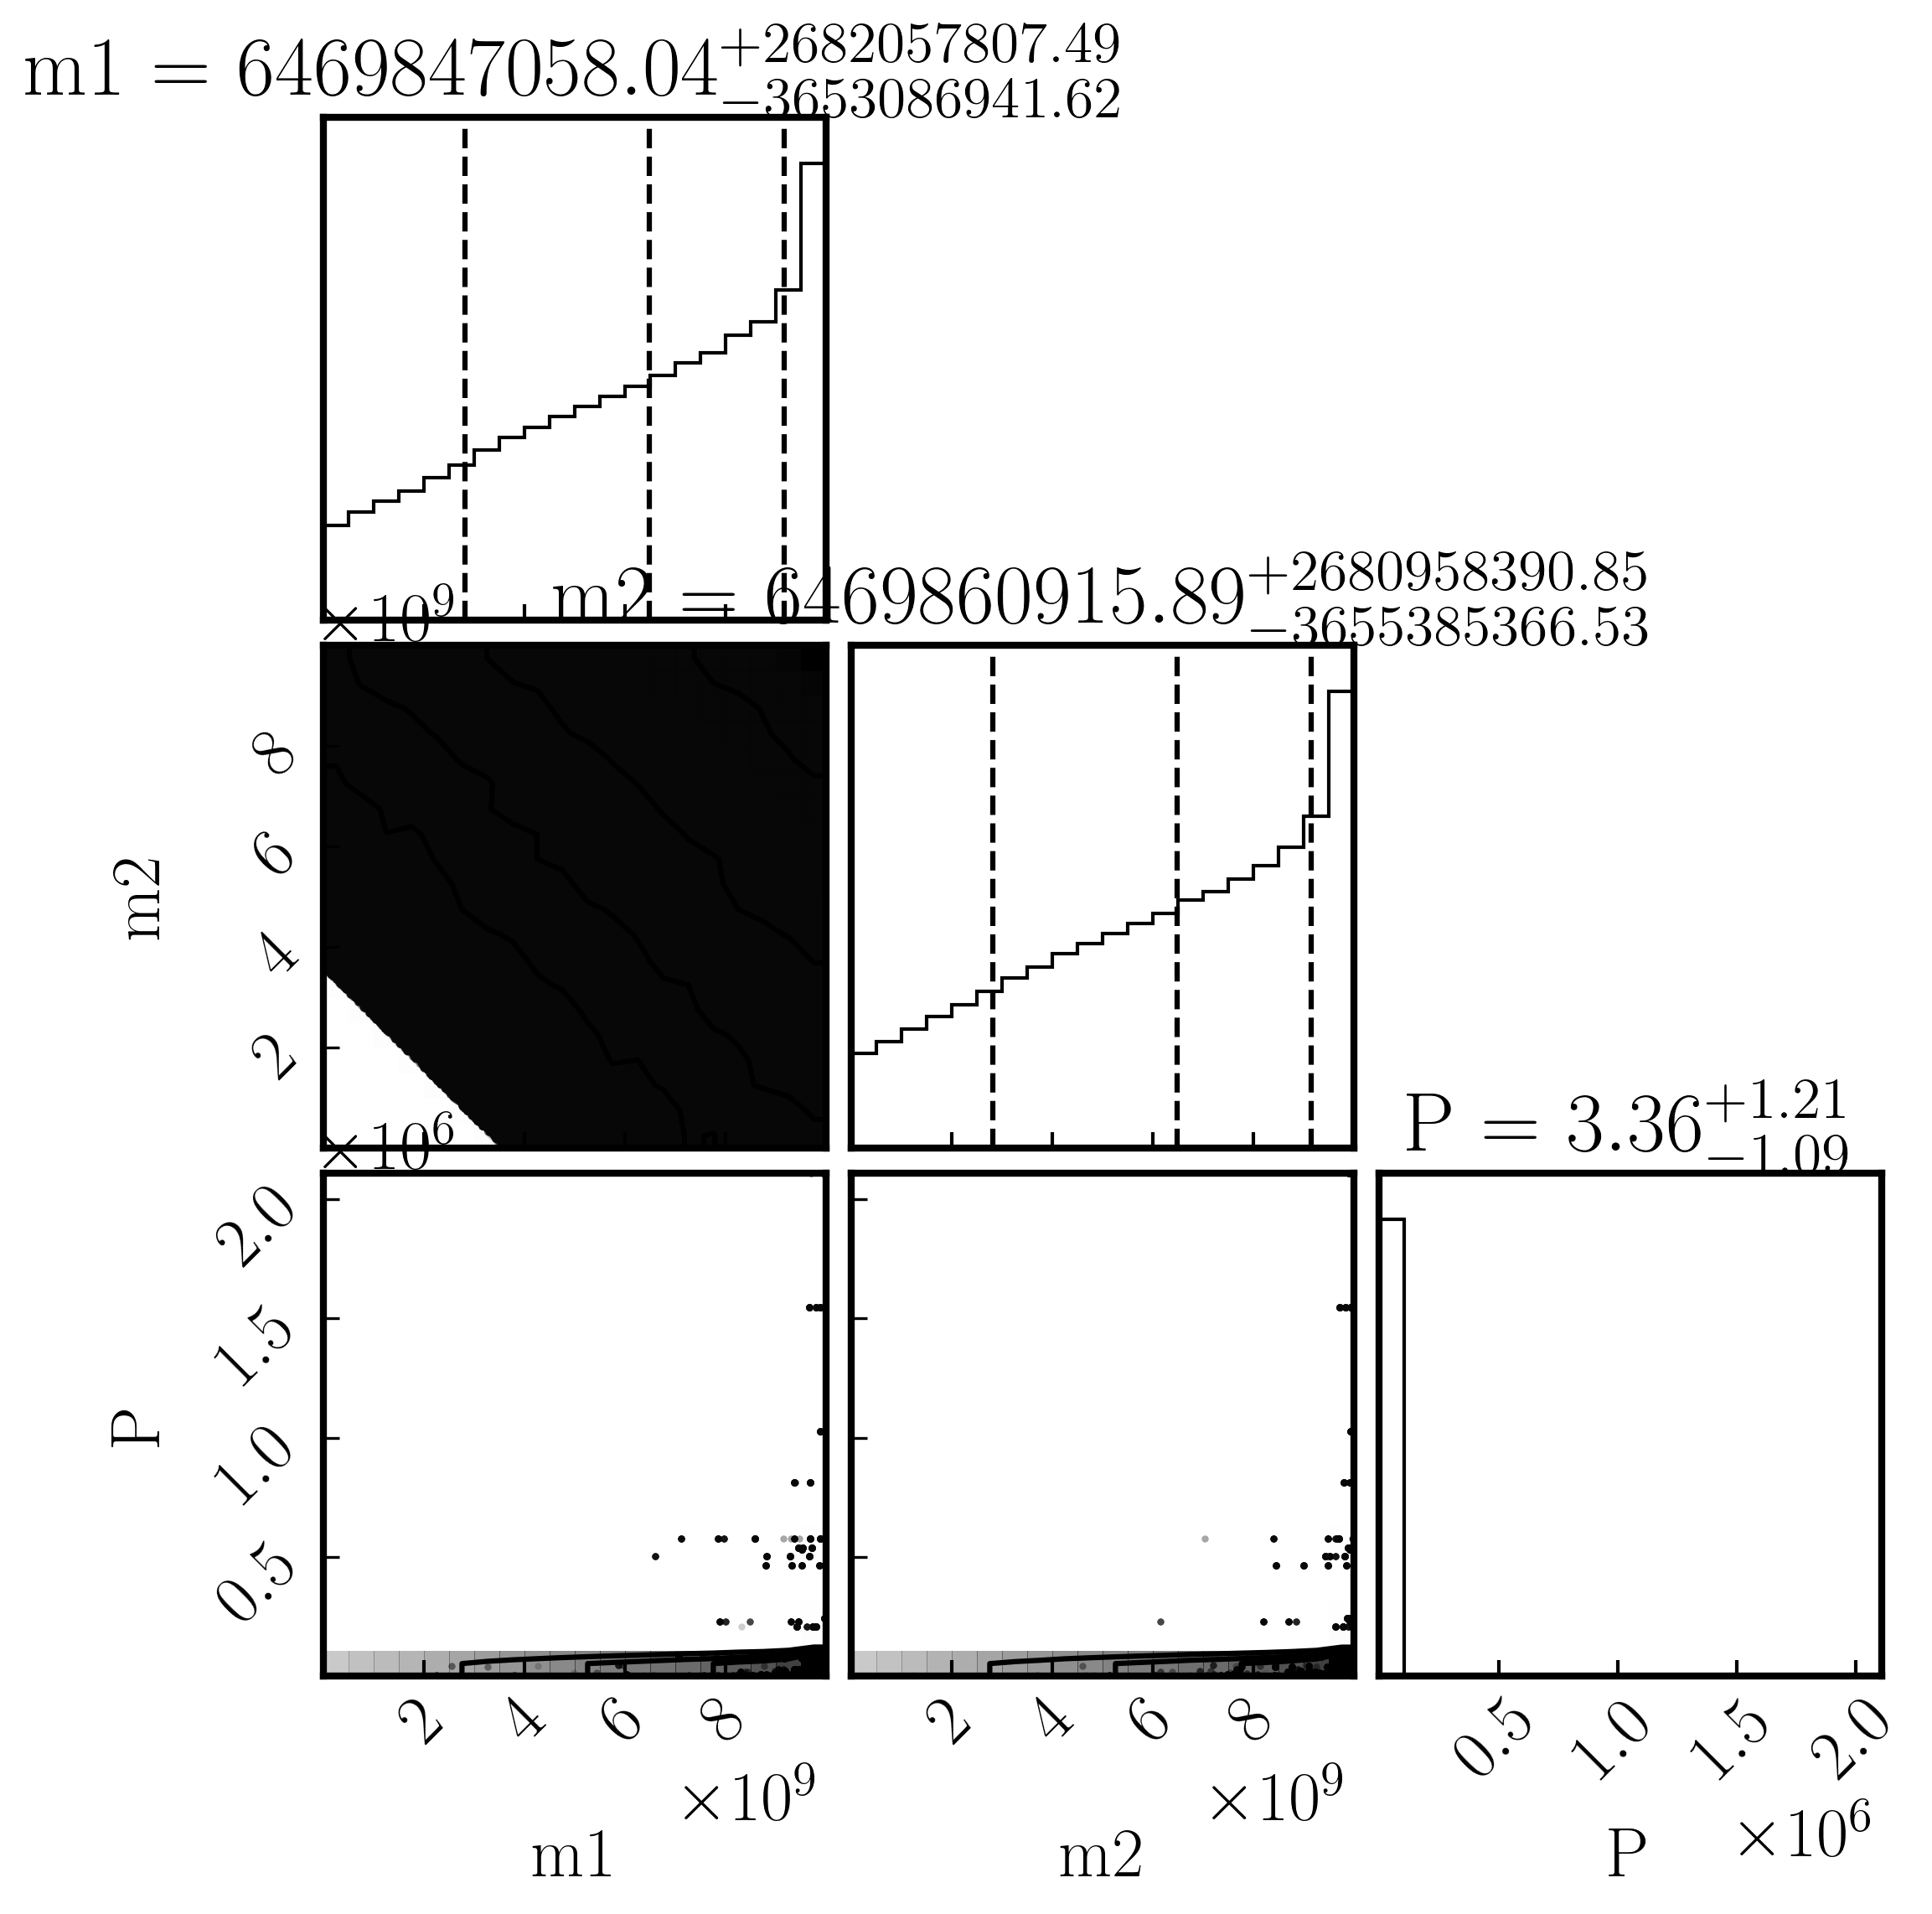

In [146]:
labels = ["m1","m2","P","sin3i"]
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])